# Mask R-CNN 
We will do object detection using Mask R-CNN, developed by Matterport and updated by akTwelve. This library cannot by directly installed using pip install. We have to do it manually. 
+ Clone the project from: https://github.com/matterport/Mask_RCNN. (for tensforflow v1)
+ https://github.com/akTwelve/Mask_RCNN (for tensorflow v2)
Copy it to a destination file of your choosing and unzip.
+ Run 'python setup.py install' in the command line (from the project directory you just created).



# 0. Loading general libraries

In [18]:
import os
import cv2
import keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from skimage.io import imread



# 1. Reading in the images and annotations


## 1.1 Exploring the data

1. Define the paths were the images and annotations can be found.
2. Check how many images can be found in the directory and how many annotations (they should be equal).
3. Check the names of the first five files in both directories (to make sure that they are in the same order to be able to match them)

1. Define paths

In [8]:
mask_dir=  "./Lung/Lung_masks/"
images_dir = "./Lung/Lung_images/"


2. Check amount of images and masks

In [9]:
from os import listdir

print(len(listdir(images_dir)))
print(len(listdir(mask_dir)))

704
704


3. Check the names of the first five files

In [10]:
print(listdir(images_dir)[0:5])
print(listdir(mask_dir)[0:5])

['CHNCXR_0001_0.jpg', 'CHNCXR_0002_0.jpg', 'CHNCXR_0003_0.jpg', 'CHNCXR_0004_0.jpg', 'CHNCXR_0005_0.jpg']
['CHNCXR_0001_0_mask.jpg', 'CHNCXR_0002_0_mask.jpg', 'CHNCXR_0003_0_mask.jpg', 'CHNCXR_0004_0_mask.jpg', 'CHNCXR_0005_0_mask.jpg']


## 1.2 Constructing train and test-datasets
1. Define a mrcnn.utils.Dataset object. This has to contain at least three functions.
    1. load_dataset:  add the extra class for lung and load in the images
        + add an argument so that you can use the function to both load in the test and training set
    2. load_masks: load in the masks for the image
    3. image_reference: load in an image_reference for each image
2. Load in the training and the test-set, using load_dataset()

1. Define a mrcnn.utils.Dataset object

In [11]:
# split into train and test set
from os import listdir
from numpy import asarray
from mrcnn.utils import Dataset
from numpy import zeros

# class that defines and loads the kangaroo dataset
class LungDataset(Dataset):
    
    # 1. load the dataset images and classes
    def load_dataset(self, dataset_dir, is_train=True):
        
        # define the classes: here the class 'lung', which gets assigned the value 1
        self.add_class("dataset", 1, "lung")
        
        # find all images
        for idx, filename in enumerate(listdir(images_dir)): 
            # extract image id
            image_id = filename[:-4]
            # skip all images after 100 if we are building the train set
            if is_train and idx >= 100:
                continue
            # skip all images before 100 and after 199 if we are building the test/val set (only want 100 in testset as well)
            if not is_train and idx < 100 or idx > 199:
                continue
            img_path = images_dir + filename
            mask_path = mask_dir + image_id + '_mask.jpg'
            # add to dataset
            self.add_image('dataset', image_id=image_id, path=img_path, annotation=mask_path)
           
    # load the masks for an image
    def load_mask(self, image_id):
        # get details of image
        info = self.image_info[image_id]
        # define box file location
        path = info['annotation']
        # create mask
        class_ids = list()
        h = imread(path, as_gray=True).shape[0]
        w = imread(path, as_gray=True).shape[1]
        masks = zeros([h, w, 1], dtype='uint8')
        for i in range(1):    # There is only 1 mask per picture
            masks[:,:,i] = imread(path, as_gray=True)
            class_ids.append(self.class_names.index('lung'))
        return masks, asarray(class_ids, dtype='int32')
        
    # load an image reference
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']


2. Load in the training and test set

In [12]:
# train set
train_set = LungDataset()
train_set.load_dataset('Lung', is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))
 
# test/val set
test_set = LungDataset()
test_set.load_dataset('Lung', is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))


Train: 100
Test: 100


In [13]:
train_set.load_image(0).shape

(730, 750, 3)

In [14]:
test_set.load_image(0).shape

(730, 750, 3)

## 1.3 Taking a look at the dataset
1. Load an image and plot it
2. Load the mask of the previous image and plot it
3. Combine image and maks in one plot, using the display_instances- function 

1. Load an image and plot is


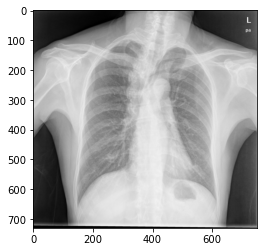

In [19]:
# load image
image_id = 21
image = train_set.load_image(image_id)

# plot image
plt.imshow(image)
plt.show()

2. Load and plot the mask

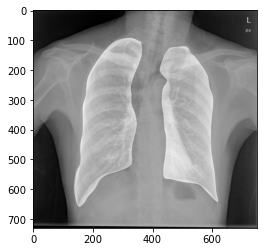

In [20]:
# load image mask
mask, class_ids = train_set.load_mask(image_id)

# plot 
plt.imshow(image)
# plot masks
for i in range(mask.shape[2]):
    plt.imshow(mask[:, :, i], cmap='gray', alpha=0.3)
plt.show()

3. Combine both

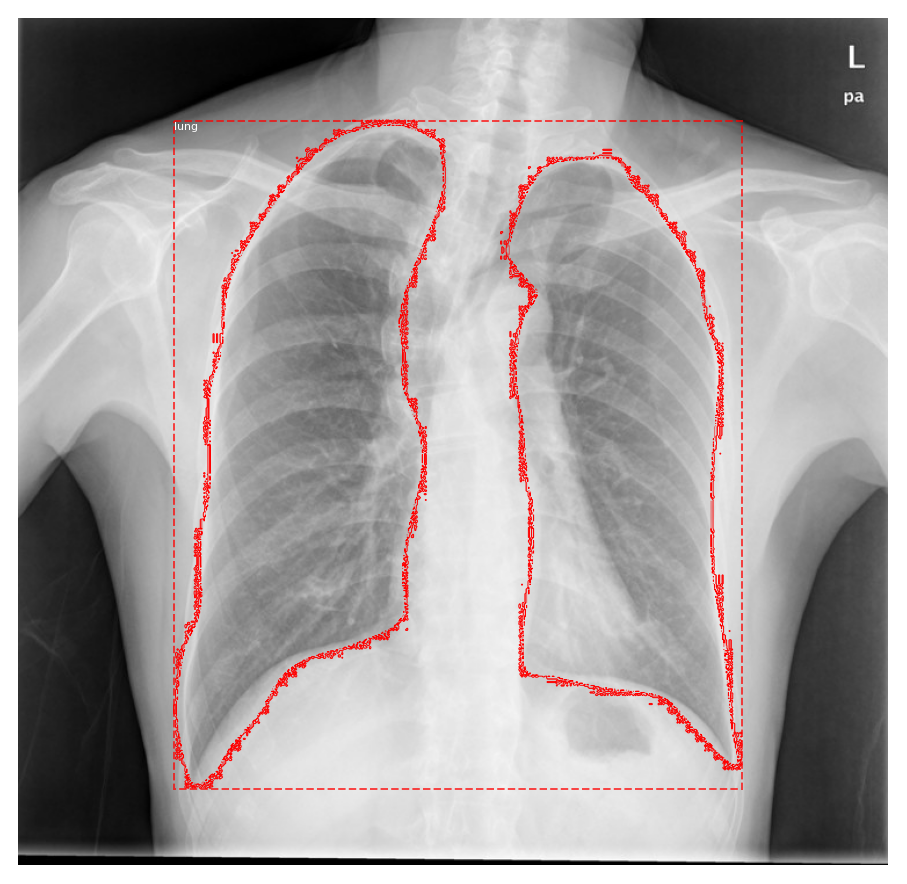

In [21]:
from mrcnn.visualize import display_instances
from mrcnn.utils import extract_bboxes

# extract bounding boxes from the masks
bbox = extract_bboxes(mask)
# display image with masks and bounding boxes
display_instances(image, bbox, mask, class_ids, train_set.class_names)

Don't mind the strange contours. This is because I lowered the quality of the images, so the models could train faster.

# 2. Training Mask R-CNN Model for lung Detection

We do transfer learning, using a model that is pretrained on the COCO dataset
Do the following steps:

1. Configure the model to fit our dataset
    + Give the configuration a logic name
    + Define the number of classes (2)
    + Define the number of training steps per epoch
        This is equal to the number of images in the training set (1 image per batch)

2. Load the model
3. Load the pre-trained weights from the coco-dataset
4. Train the model
    + But stop it as soon as it starts running without problems.(it will trow some errors, but that is ok) This would take several hours. 
5. Plot the results (I gave the results of my run in the notebook)
    + for mrcnn_class_loss and  val_mrcnn_class_loss (how good are the classifications )
    + for mrcnn_bbox_loss and  val_bbox_class_loss (how good are the bounding boxes)

1. Configure the model

In [22]:
from mrcnn.config import Config
# define a configuration for the model
class LungConfig(Config):
    # Give the configuration a recognizable name
    NAME = "lung_cfg"
    # Number of classes (background + kangaroo)
    NUM_CLASSES = 1 + 1
    # Number of training steps per epoch
    STEPS_PER_EPOCH = 100

# prepare config
config = LungConfig()

2. Load the model

In [23]:
from mrcnn.model import MaskRCNN
model = MaskRCNN(mode='training', model_dir='./', config=config)

3. Load the weigths

In [25]:
model.load_weights('mask_rcnn_coco.h5', by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",
                                                               "mrcnn_bbox", "mrcnn_mask"])

4. Train the model

In [27]:
history = model.train(train_set, test_set, learning_rate=config.LEARNING_RATE, epochs=20, layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: ./lung_cfg20211104T1356\mask_rcnn_lung_cfg_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
rpn_model              (Functional)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistributed)
mrcnn_bbox_fc          (TimeDistributed)
mrcnn_mask_deconv      (TimeDistributed)
m

C:\Anaconda\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/20


C:\Anaconda\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Anaconda\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Anaconda\lib\site-packages\tensorflow\python\framework\indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("training/SGD/gradients/gradients/roi_align_classifier/concat_grad/sub:0", shape=(None,), dtype=int32),

  1/100 [..............................] - ETA: 53:35 - batch: 0.0000e+00 - size: 2.0000 - loss: 56.6068 - rpn_class_loss: 44.3519 - rpn_bbox_loss: 12.2251 - mrcnn_class_loss: 0.0298 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

C:\Anaconda\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Anaconda\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/100 [..............................] - ETA: 45:22 - batch: 0.5000 - size: 2.0000 - loss: 51.1270 - rpn_class_loss: 39.8519 - rpn_bbox_loss: 11.2602 - mrcnn_class_loss: 0.0149 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00    

C:\Anaconda\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Anaconda\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/100 [..............................] - ETA: 45:17 - batch: 1.0000 - size: 2.0000 - loss: 41.0348 - rpn_class_loss: 31.4685 - rpn_bbox_loss: 9.5564 - mrcnn_class_loss: 0.0099 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00 

C:\Anaconda\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Anaconda\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/100 [>.............................] - ETA: 44:58 - batch: 1.5000 - size: 2.0000 - loss: 34.1537 - rpn_class_loss: 24.1216 - rpn_bbox_loss: 8.2461 - mrcnn_class_loss: 0.0335 - mrcnn_bbox_loss: 1.5603 - mrcnn_mask_loss: 0.1921        

C:\Anaconda\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Anaconda\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/100 [>.............................] - ETA: 44:29 - batch: 2.0000 - size: 2.0000 - loss: 28.7595 - rpn_class_loss: 19.4151 - rpn_bbox_loss: 7.9156 - mrcnn_class_loss: 0.0268 - mrcnn_bbox_loss: 1.2483 - mrcnn_mask_loss: 0.1537

C:\Anaconda\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Anaconda\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/100 [>.............................] - ETA: 44:06 - batch: 2.5000 - size: 2.0000 - loss: 25.6686 - rpn_class_loss: 16.2489 - rpn_bbox_loss: 7.6003 - mrcnn_class_loss: 0.0275 - mrcnn_bbox_loss: 1.5490 - mrcnn_mask_loss: 0.2428

C:\Anaconda\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Anaconda\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


KeyboardInterrupt: 

We get several scores
+ rpn_bbox_loss: how good are the suggested bounding boxes from the RPN-model that selects the regions in the train set
+ rpn_class_loss: how good are the classification from the RPN model in the train set

+ mrcnn_class_loss: how good are the classifications in the train model
+ mrcnn_bbox_loss: how good are the bounding boxes in the train model
+ mrcn_mask_loss: how good are the masks in the train model

+ all the same scores for the validation set.



5. Plot the results 

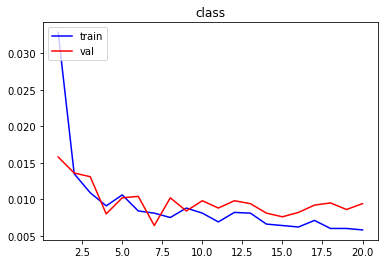

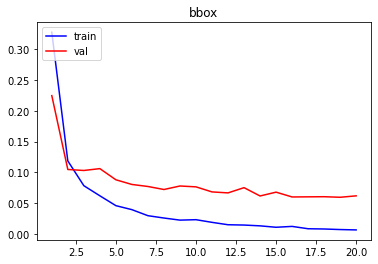

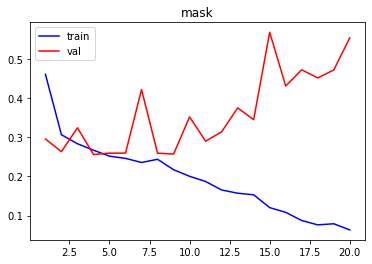

In [28]:
mrcnn_class_loss = [0.0329, 0.0135, 0.0109, 0.0091, 0.0106, 0.0084, 0.0081, 0.0075, 0.0088, 0.0081, 0.0069, 0.0082, 0.0081, 0.0066, 0.0064, 0.0062, 0.0071, 0.0060, 0.0060, 0.0058 ]
mrcnn_bbox_loss =  [0.3275, 0.1186, 0.0784, 0.0620, 0.0460, 0.0395, 0.0297, 0.0259, 0.0225, 0.0232, 0.0189, 0.0150, 0.0145, 0.0132, 0.0109, 0.0123, 0.0085, 0.0081, 0.0072, 0.0066]
mrcnn_mask_loss =  [0.4610, 0.3065, 0.2835, 0.2670, 0.2517, 0.2461, 0.2356, 0.2438, 0.2171, 0.2003, 0.1870, 0.1654, 0.1571, 0.1530, 0.1203, 0.1082, 0.0873, 0.0762, 0.0790, 0.0633 ]

val_mrcnn_class_loss = [0.0158, 0.0136,0.0131, 0.0080, 0.0102, 0.0104, 0.0064, 0.0102, 0.0084, 0.0098, 0.0088, 0.0098, 0.0094, 0.0081, 0.0076, 0.0082, 0.0092, 0.0095, 0.0086, 0.0094 ]
val_mrcnn_bbox_loss = [0.2246, 0.1047, 0.1031, 0.1061, 0.0880, 0.0804, 0.0771, 0.0722, 0.0779, 0.0765, 0.0683, 0.0667, 0.0752, 0.0617, 0.0679, 0.0601, 0.0603, 0.0605, 0.0596, 0.0619]
val_mrcnn_mask_loss = [0.2956, 0.2632, 0.3243, 0.2559, 0.2595, 0.2595, 0.4220, 0.2594, 0.2570, 0.3520, 0.2900, 0.3139, 0.3751, 0.3450, 0.5684, 0.4310, 0.4724, 0.4517, 0.4719, 0.5542]

epoch = range(1,21)
plt.plot(epoch, mrcnn_class_loss, 'b',epoch, val_mrcnn_class_loss, 'r' )
plt.title('class')
plt.legend(['train', 'val'], loc='upper left')

plt.show()
plt.plot(epoch, mrcnn_bbox_loss, 'b',epoch, val_mrcnn_bbox_loss, 'r' )
plt.title('bbox')
plt.legend(['train', 'val'], loc='upper left')

plt.show()
plt.plot(epoch, mrcnn_mask_loss, 'b',epoch, val_mrcnn_mask_loss, 'r' )
plt.title('mask')
plt.legend(['train', 'val'], loc='upper left')

plt.show()

# 3. Evaluating a mask R-CNN model on the test-set

We can see that the validation score is still improving, so we should actually run a few more epochs. (But we are not going to do that now). We choose the last model as the best model. The model has automatically written the weigths away to the directory given in the maskRNN object. We gave "./", this means you will find a folder with the results for each epoch in the same directory as this python notebook. We will use the weights from epoch 5 (mask_rcnn_lung_cfg_0005.h5: see leho, since you did not let this run yourself) to make predictions and to evaluate the model.

1. Set up configuration for prediction
2. Initiate the model and load in the weights from the best model (choose the best model based on the plots)
3. Write function to evaluate model
    + load in the image
    + Scale the image to right size
    + Make prediction
    + Calculate mean average prediction
4. Use the function to evaluate performance on test and training set

In [29]:
# define the prediction configuration
class PredictionConfig(Config):
    # define the name of the configuration
    NAME = "lung_cfg"
    # number of classes (background + lung)
    NUM_CLASSES = 2
    # simplify GPU config
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
cfg = PredictionConfig()


2. Initiate model and load weights

In [30]:
# define the model
model = MaskRCNN(mode='inference', model_dir='./', config=cfg)
# load model weights
model.load_weights('mask_rcnn_lung_cfg_0005.h5', by_name=True)

Instructions for updating:
Use fn_output_signature instead


3. Write function to evaluate model

In [31]:
from mrcnn.model import mold_image
from numpy import expand_dims
from mrcnn.utils import compute_ap

# calculate the mAP for a model on a given dataset
def evaluate_model(dataset, model, cfg):
    APs = list()
    for image_id in dataset.image_ids:
        # load image, bounding boxes and masks for the image id
        image = dataset.load_image(image_id)
        mask, class_id = dataset.load_mask(image_id)
        bbox = extract_bboxes(mask) 
        
        # convert pixel values 
        scaled_image = mold_image(image, cfg)
        # convert image into one sample
        sample = expand_dims(scaled_image, 0)
        
        # make prediction
        yhat = model.detect(sample, verbose=0)
        # extract results for first sample
        r = yhat[0]
        # calculate statistics, including AP
        AP, _, _, _ = compute_ap(bbox, class_id, mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
        # store
        APs.append(AP)
    # calculate the mean AP across all images
    mAP = np.mean(APs)
    return mAP

4. Use the function to evaluate performance on test and training set

In [32]:
# evaluate model on training dataset
train_mAP = evaluate_model(train_set, model, cfg)
print("Train mAP: %.3f" % train_mAP)


C:\Anaconda\lib\site-packages\keras\engine\training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Train mAP: 0.000


In [37]:
# evaluate model on test dataset
test_mAP = evaluate_model(test_set, model, cfg)
print("Test mAP: %.3f" % test_mAP)

Test mAP: 0.000


The test- MAP is pretty good. 

# 3. Using model on new images

Choose one of the images in the test-set and predict the mask for that image.
1. Load the image
2. Scale the image
3. Make prediction
4. Display the results using  display_instances

1. Load image

(730, 750, 3)


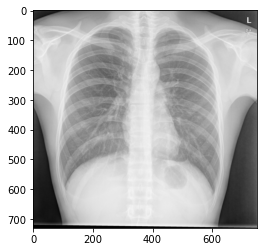

In [38]:
image_id = 0
image = test_set.load_image(image_id)
print(image.shape)
# plot image
plt.imshow(image)
plt.show()

2. Scale the image

In [39]:
# convert pixel values (e.g. center)
scaled_image = mold_image(image, cfg)
# convert image into one sample
sample = expand_dims(scaled_image, 0)

3. Make the prediction

In [40]:
# make prediction
yhat = model.detect(sample, verbose=0)

4. Display the results using  display_instances


*** No instances to display *** 



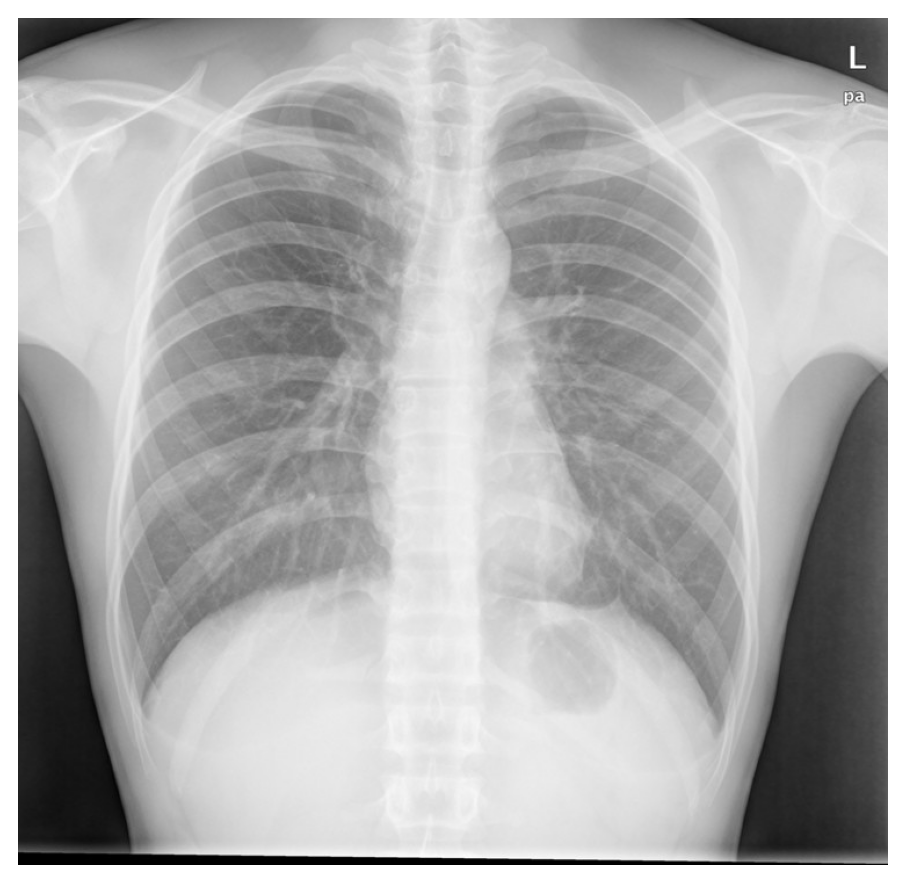

In [41]:
from mrcnn.visualize import display_instances
from mrcnn.utils import extract_bboxes

# extract bounding boxes from the masks
bbox = yhat[0]['rois']
mask = yhat[0]['masks']
class_ids = yhat[0]['class_ids']

# display image with masks and bounding boxes
display_instances(image, bbox, mask, class_ids, train_set.class_names)